In [3]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import time

## Data

#### Load MNIST digit dataset

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Reshape the images data
train_images = np.expand_dims(train_images, axis=1)
test_images = np.expand_dims(test_images, axis=1)

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Reshape the labels
train_labels = train_labels.reshape(-1, 1, 10)
test_labels = test_labels.reshape(-1, 1, 10)

#### Generating new images

In [3]:
def generate_new_images(images, labels, num_new_images):
    new_images = []
    new_labels = []
    
    for _ in range(num_new_images):
        # Select a random image from the input images
        index = np.random.randint(0, len(images) - 1)
        image = images[index][0]
        label = labels[index]
        
        # Random rotation angle
        angle = np.random.uniform(-10, 10)
        
        # Random zoom factor
        zoom_factor = np.random.uniform(0.9, 1.1)
        
        # Rotate and zoom the image
        rotated = rotate_image(image, angle)
        zoomed = zoom_image(rotated, zoom_factor)
        
        new_images.append(zoomed.reshape(1, 28, 28))
        new_labels.append(label)
        
    return np.array(new_images), np.array(new_labels)

def rotate_image(image, angle):
    height, width = image.shape
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_NEAREST)
    return rotated

def zoom_image(image, zoom_factor):
    height, width = image.shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    zoomed = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    zoomed = cv2.resize(zoomed, (width, height), interpolation=cv2.INTER_NEAREST)
    return zoomed

In [ ]:
generated_images, new_labels = generate_new_images(train_images, train_labels, 300000)
train_images = np.concatenate((train_images, generated_images))
train_labels = np.concatenate((train_labels, new_labels))

train_images.shape

(360000, 1, 28, 28)

## Defining the models

In [5]:
from cnn import ConvolutionalLayer, MaxPooling, InstanceNorm, Reshape, Dense
from activations import ELU, Softmax
from auxiliary import predict, train, categorical_cross_entropy, categorical_cross_entropy_prime

In [6]:
network_1 = [
    ConvolutionalLayer((1, 28, 28), 2, 3, padding=1),
    ELU(),
    MaxPooling((2, 28, 28), 2, 0, 2),
    Reshape((2, 14, 14) , (1, 2 * 14 * 14)),
    Dense(2 * 14 * 14, 10),
    Softmax()
]

network_2 = [
    ConvolutionalLayer((1, 28, 28), 2, 3, padding=1),
    ELU(),
    MaxPooling((2, 28, 28), 2, 0, 2),
    ConvolutionalLayer((2, 14, 14), 4, 3, padding=1),
    ELU(),
    MaxPooling((4, 14, 14), 2, 0, 2),
    Reshape((4, 7, 7) , (1, 4 * 7 * 7)),
    Dense(4 * 7 * 7, 512),
    ELU(),
    Dense(512, 10),
    Softmax()
]

network_3 = [
    ConvolutionalLayer((1, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    ConvolutionalLayer((1, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    MaxPooling((8, 28, 28), 2, 0, 2),
    ConvolutionalLayer((8, 14, 14), 16, 3, padding=1),
    InstanceNorm(16),
    ELU(),
    ConvolutionalLayer((8, 14, 14), 16, 3, padding=1),
    InstanceNorm(16),
    ELU(),
    MaxPooling((16, 14, 14), 2, 0, 2),
    Reshape((16, 7, 7) , (1, 16 * 7 * 7)),
    Dense(16 * 7 * 7, 512),
    ELU(),
    Dense(512, 1024),
    ELU(),
    Dense(1024, 10),
    Softmax()
]

network_3 = [
    ConvolutionalLayer((1, 28, 28), 32, 3, padding=1),
    InstanceNorm(32),
    ELU(),
    ConvolutionalLayer((1, 28, 28), 32, 3, padding=1),
    InstanceNorm(32),
    ELU(),
    MaxPooling((32, 28, 28), 2, 0, 2),
    ConvolutionalLayer((32, 14, 14), 64, 3, padding=1),
    InstanceNorm(64),
    ELU(),
    ConvolutionalLayer((64, 14, 14), 64, 3, padding=1),
    InstanceNorm(64),
    ELU(),
    MaxPooling((64, 14, 14), 2, 0, 2),
    Reshape((64, 7, 7) , (1, 64 * 7 * 7)),
    Dense(64 * 7 * 7, 512),
    ELU(),
    Dense(512, 1024),
    ELU(),
    Dense(1024, 10),
    Softmax()
]

#### Testing the forward and backward pass runtimes

In [7]:
def test_time(network, totals_only=False):
    output =train_images[0]
    tot = 0
    for layer in network:
        start = time.time()
        output = layer.forward(output)
        stop = time.time()

        if not totals_only:
            print(f"\tForward {layer.__class__.__name__} time: {stop - start}")
        tot += stop - start

    print(f"Forward total: {tot}")

    y = train_labels[0]
    grad = categorical_cross_entropy_prime(y, output)
    tot = 0
    for layer in reversed(network):
        start = time.time()
        grad = layer.backward(grad, 0)
        stop = time.time()

        if not totals_only:
            print(f"\tBackward {layer.__class__.__name__} time: {stop - start}")
        tot += stop - start

    print(f"Backward total: {tot}")

In [10]:
networks = [network_3]

for i, network in enumerate(networks):
    print(f"Network {i+1}:")
    test_time(network, totals_only=False)

Network 1:
	Forward ConvolutionalLayer time: 0.002000570297241211
	Forward InstanceNorm time: 0.0
	Forward ELU time: 0.0
	Forward ConvolutionalLayer time: 0.0009999275207519531
	Forward InstanceNorm time: 0.0010004043579101562
	Forward ELU time: 0.0
	Forward MaxPooling time: 0.04646873474121094
	Forward ConvolutionalLayer time: 0.0311431884765625
	Forward InstanceNorm time: 0.0
	Forward ELU time: 0.0
	Forward ConvolutionalLayer time: 0.06755852699279785
	Forward InstanceNorm time: 0.0
	Forward ELU time: 0.0
	Forward MaxPooling time: 0.020163297653198242
	Forward Reshape time: 0.0
	Forward Dense time: 0.002002239227294922
	Forward ELU time: 0.0
	Forward Dense time: 0.0
	Forward ELU time: 0.0
	Forward Dense time: 0.0
	Forward Softmax time: 0.0
Forward total: 0.17133688926696777
	Backward Softmax time: 0.0
	Backward Dense time: 0.0
	Backward ELU time: 0.0
	Backward Dense time: 0.009549140930175781
	Backward ELU time: 0.0
	Backward Dense time: 0.021259069442749023
	Backward Reshape time: 0

## Training

In [12]:
networks = [network_3]

In [13]:
# train
all_errors = []
all_test_scores = []
totals = []
for i, network in enumerate(networks):
    print(f"Network {i+1}:")
    errors, test_scores = train(
        network,
        categorical_cross_entropy,
        categorical_cross_entropy_prime,
        train_images,
        train_labels,
        test_images,
        test_labels,
        epochs=150 * (i + 1),
        learning_rate=0.01,
        lr_decay=0.999,  ##[0.985, 0.992, 0.995][i],
        batch_size=128,   # 128
        test_epochs=5
    )

    all_errors.append(errors)
    all_test_scores.append(test_scores)

    # test
    correct = 0
    for x, y in zip(test_images, test_labels):
        output = predict(network, x)
        correct += np.argmax(output) == np.argmax(y)

    totals.append(correct / len(test_images))

    print(f"Network {i+1} test accuracy: {correct / len(test_images)}")

for i, network in enumerate(networks):
    print(f"Network {i+1}: {totals[i]}")

Network 1:
1/150, error=0.6699397857466225, lr = 0.01
2/150, error=0.32144569976665366, lr = 0.00999
3/150, error=0.28085821429385455, lr = 0.009980010000000001
4/150, error=0.1970555670586705, lr = 0.00997002999
5/150, error=0.2526750506764079, lr = 0.00996005996001
6/150, error=0.11560122810791588, lr = 0.00995009990004999
7/150, error=0.16948933806350738, lr = 0.00994014980014994
8/150, error=0.12579557189837953, lr = 0.00993020965034979
9/150, error=0.1256249713318348, lr = 0.009920279440699441
10/150, error=0.13835782538906838, lr = 0.009910359161258741
11/150, error=0.09672181041792628, lr = 0.009900448802097483
12/150, error=0.07482730116287215, lr = 0.009890548353295385
13/150, error=0.054707033416623495, lr = 0.00988065780494209
14/150, error=0.10836666073926332, lr = 0.009870777147137147
15/150, error=0.09868049117090692, lr = 0.00986090636999001
16/150, error=0.05574068386919106, lr = 0.00985104546362002
17/150, error=0.048424829877619, lr = 0.0098411944181564
18/150, error=

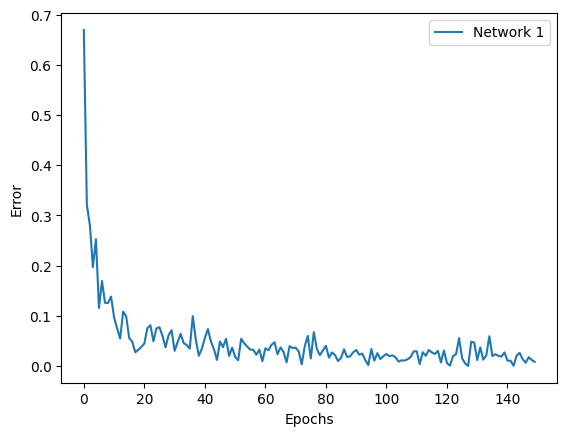

In [14]:
import matplotlib.pyplot as plt

for i, errors in enumerate(all_errors):
    plt.plot(errors, label=f"Network {i+1}")

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()

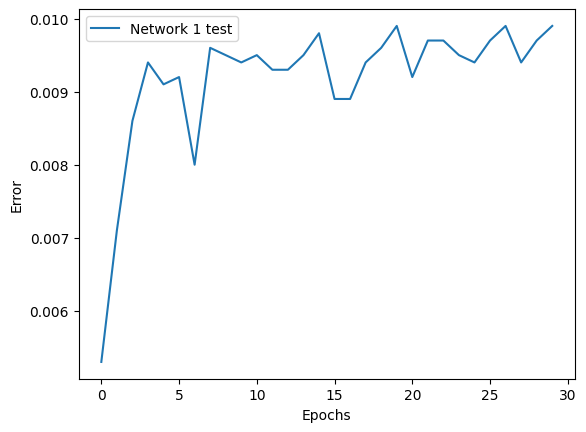

In [15]:
for i, test_scores in enumerate(all_test_scores):
    plt.plot(np.arange(0, len(test_scores)), test_scores, label=f"Network {i+1} test")

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()

In [66]:
network = network_3

# test which images are labelled correctly
correct = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
wrong_images = []
wrong_predictions = []
for x, y in zip(test_images, test_labels):
    output = predict(network, x)
    correct[np.argmax(y)].append(np.argmax(output) == np.argmax(y))
    if np.argmax(output) != np.argmax(y):
        wrong_images.append(x)
        wrong_predictions.append(output)

for i in range(10):
    print(f"Number {i}: {sum(correct[i])} / {len(correct[i])}")

Number 0: 974 / 980
Number 1: 1119 / 1135
Number 2: 1006 / 1032
Number 3: 995 / 1010
Number 4: 969 / 982
Number 5: 878 / 892
Number 6: 929 / 958
Number 7: 1000 / 1028
Number 8: 943 / 974
Number 9: 977 / 1009


In [67]:
for i in range(10):
    print(f"Number {i}: {sum(correct[i]) / len(correct[i])}")

Number 0: 0.9938775510204082
Number 1: 0.9859030837004406
Number 2: 0.9748062015503876
Number 3: 0.9851485148514851
Number 4: 0.9867617107942973
Number 5: 0.984304932735426
Number 6: 0.9697286012526096
Number 7: 0.9727626459143969
Number 8: 0.9681724845995893
Number 9: 0.9682854311199207
